In [ ]:
# Import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import random

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Random Seed for dataset generation
sampling_seed = 78
torch.manual_seed(sampling_seed)

data = np.loadtxt('MeasuredData.txt', delimiter=' ')
x_train = data[:,0]
y_train = data[:,1]
"""std_hat = []
x_std = []

num = 50 #points to calculate std dev.
for i in range(len(x_train)-num):
    vect = y_train[i:i+num]
    std_dev = np.std(vect)
    if std_dev < 0.33: #this is just because there were some outliers near to the region without points
        x_std.append(4*x_train[i+num//2+1]) #transform time in [0,1]
        std_hat.append(3*std_dev)
plt.grid(True, which="both", ls=":")
plt.scatter(x_std,std_hat,s=10)
plt.xlabel("temp")
plt.ylabel("temp 0")

data_train = np.concatenate([np.array(x_std).reshape(-1,1), np.array(std_hat).reshape(-1,1)],1)
data_train.shape"""

'std_hat = []\nx_std = []\n\nnum = 50 #points to calculate std dev.\nfor i in range(len(x_train)-num):\n    vect = y_train[i:i+num]\n    std_dev = np.std(vect)\n    if std_dev < 0.33: #this is just because there were some outliers near to the region without points\n        x_std.append(4*x_train[i+num//2+1]) #transform time in [0,1]\n        std_hat.append(3*std_dev)\nplt.grid(True, which="both", ls=":")\nplt.scatter(x_std,std_hat,s=10)\nplt.xlabel("temp")\nplt.ylabel("temp 0")\n\ndata_train = np.concatenate([np.array(x_std).reshape(-1,1), np.array(std_hat).reshape(-1,1)],1)\ndata_train.shape'

In [4]:
class NeuralNet(nn.Module):
    
    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 activation_name):

        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation_name = activation_name
        self.activation = self.get_activation(activation_name)
        # Regularization parameter
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization
        self.retrain_seed = retrain_seed

        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)

        self.init_xavier()

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                if self.activation_name in ['tanh', 'relu']:
                    gain = nn.init.calculate_gain(self.activation_name)
                else:
                    gain = 1
                torch.nn.init.xavier_uniform_(m.weight, gain=gain)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return reg_loss

    def get_activation(self, activation_name):
        if activation_name in ['tanh']:
            return nn.Tanh()
        elif activation_name in ['relu']:
            return nn.ReLU(inplace=True)
        elif activation_name in ['lrelu']:
            return nn.LeakyReLU(inplace=True)
        elif activation_name in ['sigmoid']:
            return nn.Sigmoid()
        elif activation_name in ['softplus']:
            return nn.Softplus(beta=4)
        elif activation_name in ['celu']:
            return nn.CELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)

In [5]:
def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(0 * x_.shape[0] / 100)
    training_size = x_.shape[0] - validation_size
    valid_index = random.sample(range(x_.shape[0]), validation_size)

    x_val = x_[valid_index, :]
    y_val = y_[valid_index, :]

    def th_delete(tensor, indices):
        mask = torch.ones(tensor.numel(), dtype=torch.bool)
        mask[indices] = False
        return tensor[mask]

    x_train = th_delete(x_, valid_index)
    y_train = th_delete(y_, valid_index)

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    #y_test_pred = my_network(x_test).reshape(-1, )
    y_val_pred = my_network(x_val).reshape(-1, )
    y_train_pred = my_network(x_train).reshape(-1, )

    # Compute the relative training error
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print("Relative Training Error: ", relative_error_train.detach().numpy() ** 0.5 * 100, "%")

    # Compute the relative validation error
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print("Relative Validation Error: ", relative_error_val.detach().numpy() ** 0.5 * 100, "%")

    return relative_error_train.item(), relative_error_val.item(), my_network

In [6]:
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, )) ** p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

In [ ]:
hyperparameters_configurations = {
        "hidden_layers": [1, 2],
        "neurons": [20, 25, 30],
        "regularization_exp": [2],
        "regularization_param": [0, 1e-4],
        "batch_size": [613],
        "epochs": [1000],
        "optimizer": ["LBFGS"],
        "init_weight_seed": [567, 134],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

my_nets = list()
train_err_conf = list()
val_err_conf = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_net = run_single_configuration(setup_properties, torch.from_numpy(data_train[:,0].reshape(-1,1)).type(torch.float32), torch.from_numpy(data_train[:, 1]).reshape(-1,1).type(torch.float32))
    train_err_conf.append(relative_error_train_)
    val_err_conf.append(relative_error_val_)
    my_nets.append(my_net)

train_err_conf = np.array(train_err_conf)
val_err_conf = np.array(val_err_conf)
my_nets = np.array(my_nets)

NETWORK FOR THE MEAN

In [7]:
xx = torch.from_numpy(4*x_train.reshape(-1,1)).type(torch.float32)
yy = torch.from_numpy((y_train.reshape(-1,1)-min(y_train))/(max(y_train)- min(y_train))).type(torch.float32)


In [ ]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [30],
        "regularization_exp": [2],
        "regularization_param": [0],
        "batch_size": [5],
        "epochs": [2000],
        "optimizer": ["ADAM"],
        "init_weight_seed": [128],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

my_nets_mean = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    _, _, my_net = run_single_configuration(setup_properties, xx, yy)
    my_nets_mean.append(my_net)

my_nets_mean = np.array(my_nets_mean)

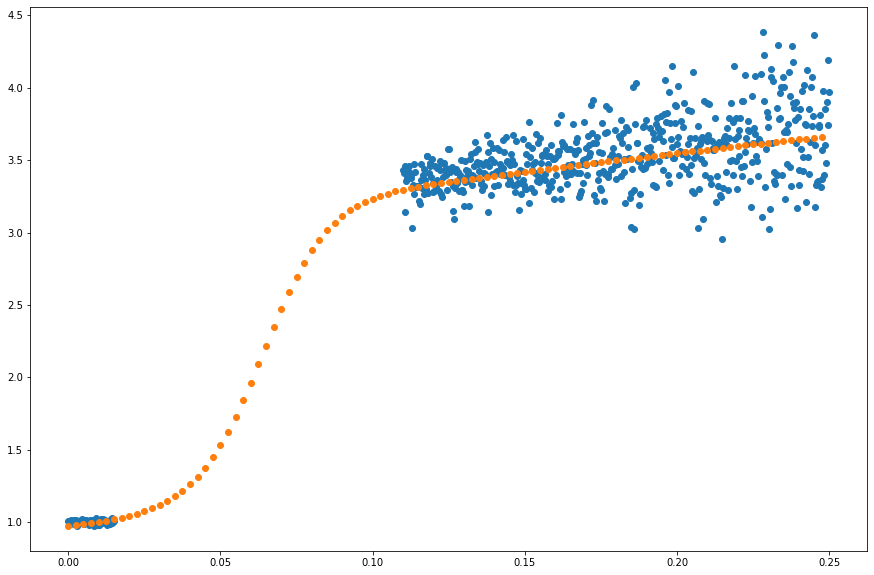

In [19]:
xxx = np.arange(100).reshape(-1,1)/100

#y_pred_fake = y_pred_fake*(maxmeasy-minmeasy)+minmeasy
for i in range(len(my_nets_mean)):
    plt.figure(figsize=(15, 10))
    plt.scatter(x_train,y_train)
    yyy = my_nets_mean[i](torch.from_numpy(xxx).type(torch.float32)) * (max(y_train)- min(y_train)) + min(y_train)
    plt.scatter(xxx/4, yyy.detach())
    plt.show()


In [ ]:
num_bin=50
import numpy as np
stdbin1 = list()
#print(np.linspace(0,0.25,num_bin+1))
#print(range(24))
measured_data=torch.from_numpy(data)
for i in np.linspace(0,0.25,num_bin+1): #np.linspace(0,0.24,24)
    stdbin=0
    count=0
    index=list()
    for j in range(622):
        if (measured_data[j,0]<i+0.25/num_bin and measured_data[j,0]>=i):
            index.append(j)
            count=count+1
    #print(index)
    if (count==0 or count==1):
        stdbin = torch.Tensor([0]).squeeze()
        #print(stdbin)
    else:
        stdbin = torch.std(measured_data[index,1])
    #stdbin1.torch.attach(stdbin)  
    #stdbin1 = torch.cat((stdbin1, stdbin), 0)
    stdbin1.append(stdbin)
stdbin1 = torch.stack(stdbin1)
print(stdbin1)

In [ ]:
times = torch.from_numpy(np.linspace(0.25/(num_bin*2),0.25+0.25/(num_bin*2),num_bin+1))
print(stdbin1.size())
print(times.size())
train_bin = torch.cat((times.resize(num_bin+1,1),stdbin1.resize(num_bin+1,1)),1)
train_bin1=train_bin[train_bin[:,1]>0]

In [11]:
miny=torch.min(train_bin1[:,1])
maxy=torch.max(train_bin1[:,1])
minx=torch.min(train_bin1[:,0])
maxx=torch.max(train_bin1[:,0])

train_x1 = ((train_bin1[:,0]-minx)/(maxx-minx)).unsqueeze(1)
train_y1 = ((train_bin1[:,1]-miny)/(maxy-miny)).unsqueeze(1)



In [19]:
hyperparameters_configurations = {
        "hidden_layers": [1, 2, 4],
        "neurons": [20, 30],
        "regularization_exp": [2],
        "regularization_param": [0, 1e-4],
        "batch_size": [31],
        "epochs": [1200],
        "optimizer": ["ADAM", "LBFGS"],
        "init_weight_seed": [128],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

my_nets_std = list()
train_err_conf = list()
val_err_conf = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_network = run_single_configuration(setup_properties, train_x1.type(torch.float32), train_y1.type(torch.float32))
    train_err_conf.append(relative_error_train_)
    val_err_conf.append(relative_error_val_)
    my_nets_std.append(my_network)

train_err_conf = np.array(train_err_conf)
val_err_conf = np.array(val_err_conf)
my_nets_std = np.array(my_nets_std)

################################### 0 ###################################
{'hidden_layers': 1, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 31, 'epochs': 1200, 'optimizer': 'ADAM', 'init_weight_seed': 128, 'activation': 'tanh'}
Final Training Loss:  0.01036047
Final Validation Loss:  nan
Relative Training Error:  19.552406668663025 %
Relative Validation Error:  nan %
################################### 1 ###################################
{'hidden_layers': 1, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 31, 'epochs': 1200, 'optimizer': 'LBFGS', 'init_weight_seed': 128, 'activation': 'tanh'}
Final Training Loss:  0.0072054
Final Validation Loss:  nan
Relative Training Error:  16.307619214057922 %
Relative Validation Error:  nan %
################################### 2 ###################################
{'hidden_layers': 1, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0.0001, 'batch_size': 31, 'ep

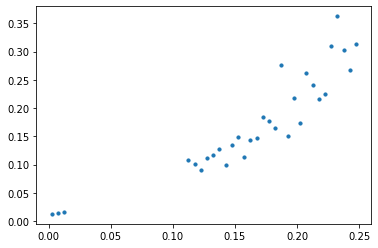

In [13]:
plt.scatter(train_bin1[:, 0],train_bin1[:, 1],s=10)


tensor([[-0.0220],
        [-0.0193],
        [-0.0167],
        [-0.0141],
        [-0.0114],
        [-0.0088],
        [-0.0061],
        [-0.0034],
        [-0.0008],
        [ 0.0019],
        [ 0.0046],
        [ 0.0074],
        [ 0.0101],
        [ 0.0128],
        [ 0.0155],
        [ 0.0183],
        [ 0.0210],
        [ 0.0238],
        [ 0.0266],
        [ 0.0294],
        [ 0.0322],
        [ 0.0350],
        [ 0.0378],
        [ 0.0406],
        [ 0.0435],
        [ 0.0463],
        [ 0.0492],
        [ 0.0521],
        [ 0.0549],
        [ 0.0578],
        [ 0.0607],
        [ 0.0636],
        [ 0.0666],
        [ 0.0695],
        [ 0.0725],
        [ 0.0754],
        [ 0.0784],
        [ 0.0814],
        [ 0.0843],
        [ 0.0873],
        [ 0.0904],
        [ 0.0934],
        [ 0.0964],
        [ 0.0994],
        [ 0.1025],
        [ 0.1056],
        [ 0.1086],
        [ 0.1117],
        [ 0.1148],
        [ 0.1179],
        [ 0.1210],
        [ 0.1241],
        [ 0.

C:\Users\Angelo\AppData\Local\Temp\ipykernel_20856\2649306708.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


tensor([[0.0102],
        [0.0123],
        [0.0144],
        [0.0164],
        [0.0185],
        [0.0206],
        [0.0227],
        [0.0248],
        [0.0268],
        [0.0288],
        [0.0309],
        [0.0329],
        [0.0349],
        [0.0369],
        [0.0389],
        [0.0409],
        [0.0428],
        [0.0448],
        [0.0467],
        [0.0486],
        [0.0505],
        [0.0524],
        [0.0542],
        [0.0561],
        [0.0579],
        [0.0598],
        [0.0616],
        [0.0634],
        [0.0652],
        [0.0669],
        [0.0687],
        [0.0705],
        [0.0722],
        [0.0740],
        [0.0758],
        [0.0775],
        [0.0793],
        [0.0810],
        [0.0828],
        [0.0846],
        [0.0864],
        [0.0882],
        [0.0900],
        [0.0919],
        [0.0937],
        [0.0956],
        [0.0976],
        [0.0996],
        [0.1016],
        [0.1037],
        [0.1058],
        [0.1080],
        [0.1103],
        [0.1127],
        [0.1151],
        [0

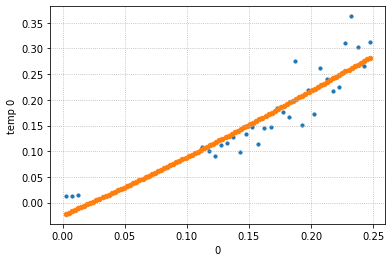

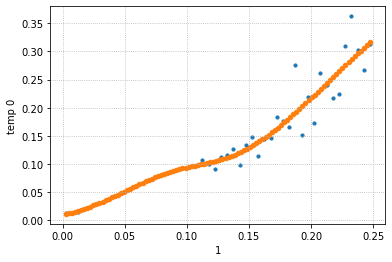

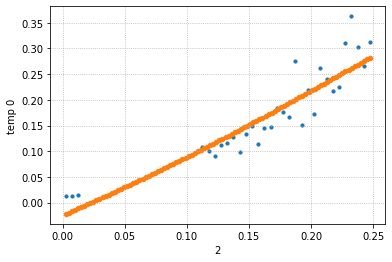

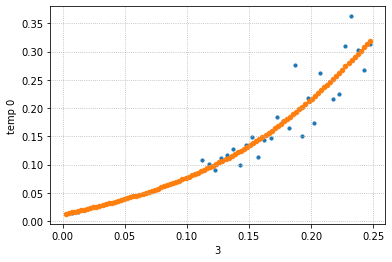

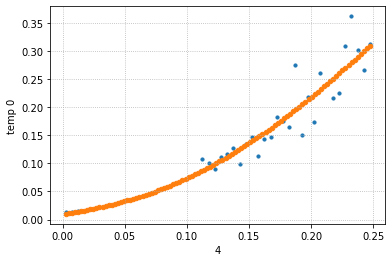

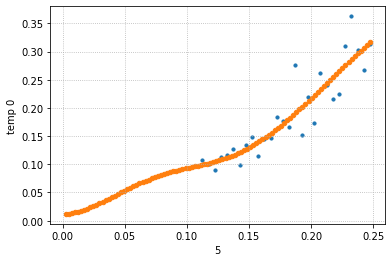

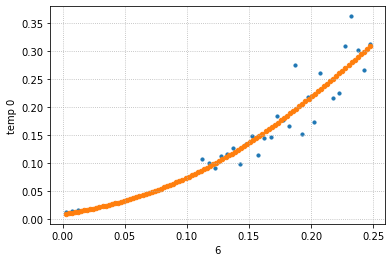

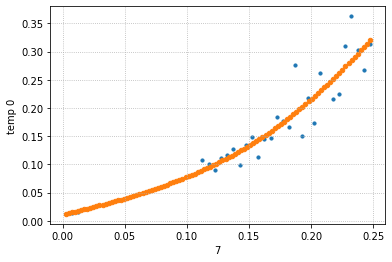

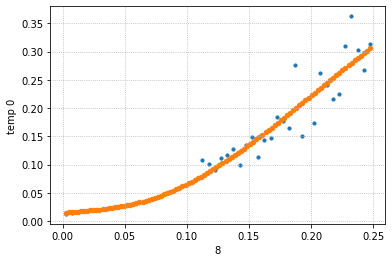

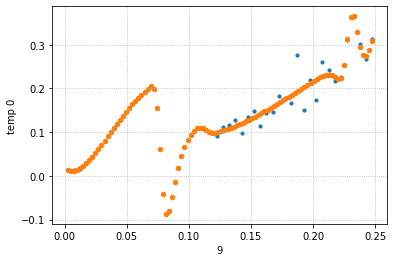

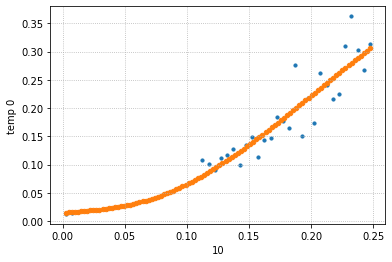

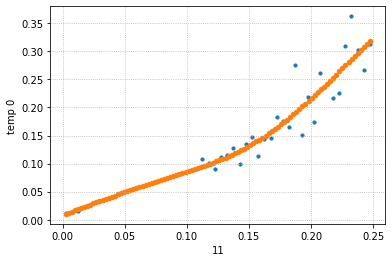

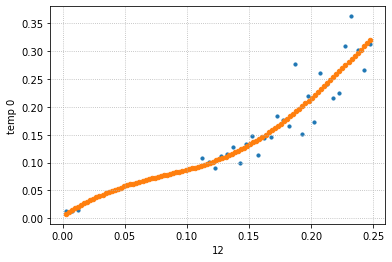

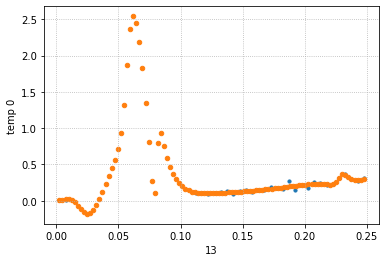

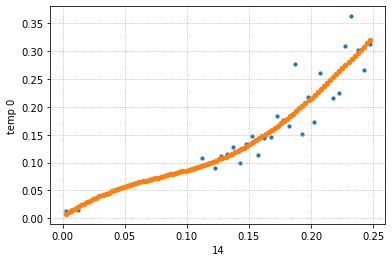

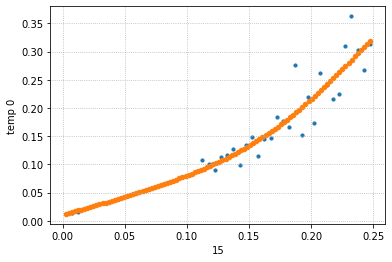

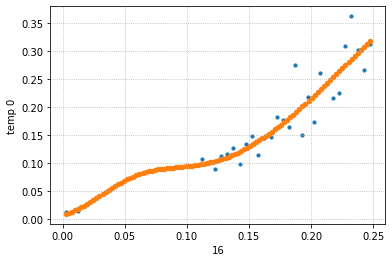

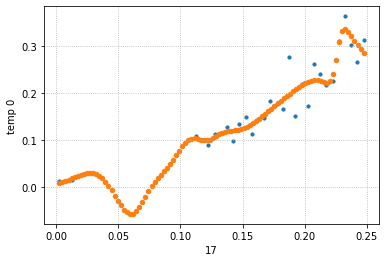

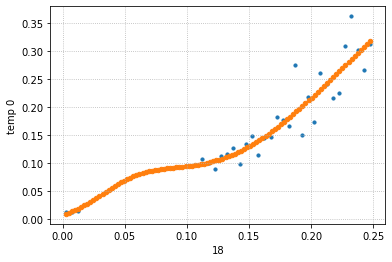

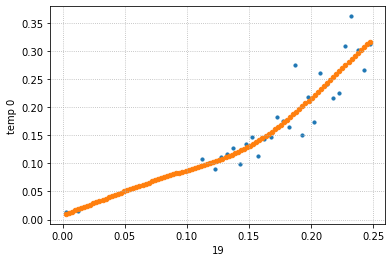

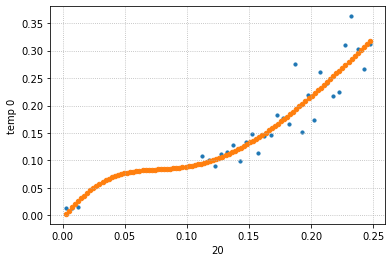

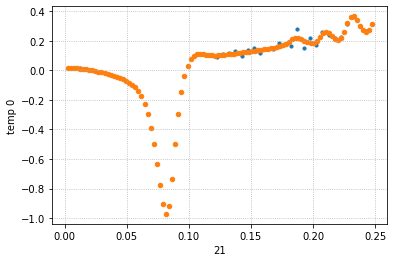

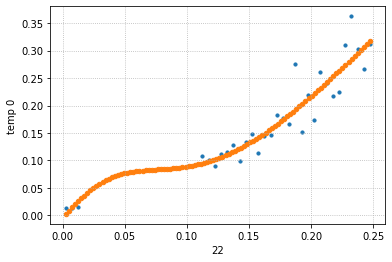

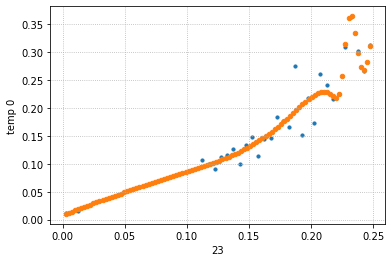

In [20]:
for i in range(len(my_nets_std)):
    plt.figure()
    plt.grid(True, which="both", ls=":")
    plt.scatter(train_bin1[:, 0],train_bin1[:, 1],s=10)
    #plt.scatter(x,z,s=10)
    plt.xlabel(i)
    plt.ylabel("temp 0")
    x_pred = np.linspace(0, 1, 100)
    y_pred=(my_nets_std[i](torch.from_numpy(x_pred.reshape(-1,1)).type(torch.float32)).detach())*(maxy-miny)+miny
    print(y_pred)
    plt.scatter(torch.from_numpy(x_pred)*(maxx-minx)+minx,y_pred, s=20)
    


In [21]:
choose=[4,5,7,8,9,16]

In [ ]:
count=0
my_nets_chosen = my_nets_std[choose]

for j in range(len(xx)):
    sum = np.zeros(1)
    for i in range(len(choose)):
        sum = sum + np.array(my_nets_chosen[i](xx[j]).reshape(-1,1).detach())/3
    res_mean = sum/(len(choose))
    if my_nets_mean[0](xx[j]).detach()*(max(y_train)- min(y_train)) + min(y_train) - res_mean < y_train[j] < my_nets_mean[0](xx[j]).detach()*(max(y_train)- min(y_train)) + min(y_train) + res_mean:
        count +=1

percentage = count/xx.shape[0]
print(percentage)

In [ ]:
x_lin=np.linspace(0,1,2000)
x_lin=torch.from_numpy(x_lin)
#plt.scatter(train_x.detach().numpy(),stdestimate.detach().numpy())
y_pred_fake2 = NNstd(x_lin.resize(2000, 1).float()) #TODO: I have to renormalize back x_lin here if I want to use standardization!!!
y_pred_fake2 = miny +y_pred_fake2*(maxy-miny)
x_lin = x_lin*(maxx-minx)+minx
#plt.plot(x_lin, y_pred_fake2.detach().numpy(), c='r')
#plt.show()
plt.scatter(train_bin1[:,0].detach().numpy(),train_bin1[:,1].detach().numpy())
plt.plot(x_lin, y_pred_fake2.detach().numpy(), c='r')
plt.show()
train_y2 = (measured_data[:,1]).unsqueeze(1)
train_x2 = (((measured_data[:,0])-minx)/(maxx-minx)).unsqueeze(1)
train_x22 = (measured_data[:,0]).unsqueeze(1)
plt.scatter(train_x22.detach().numpy(),train_y2.detach().numpy())
plt.plot(x_lin, y_pred_fake.detach().numpy(), c='r') #x_lin*(maxmeasx-minmeasx)+minmeasx
plt.plot(x_lin, (y_pred_fake+2*y_pred_fake2).detach().numpy(), c='y')  #x_lin*(maxmeasx-minmeasx)+minmeasx
plt.plot(x_lin, (y_pred_fake-2*y_pred_fake2).detach().numpy(), c='y')  #x_lin*(maxmeasx-minmeasx)+minmeasx
plt.show()
stdpred = (NNstd(train_x2.float()))*(maxy-miny)+miny

#stdpred = torch.mean(stdestimate)+stdpred*(torch.std(stdestimate))
print(train_y.size())
print(y_pred.size())
print(stdpred.size())

plt.scatter(train_x2.detach().numpy(),y_pred.detach().numpy())
plt.show()
plt.scatter(train_x2.detach().numpy(),total_y1.detach().numpy())
plt.show()
y_pred=y_pred.squeeze()
stdpred=stdpred.squeeze()
total_y1=total_y1.squeeze()

"""plt.scatter(train_x2.detach().numpy(),(y_pred + 3*stdpred).detach().numpy())
plt.scatter(train_x2.detach().numpy(),(y_pred).detach().numpy())
plt.show()"""

print(torch.sum(torch.greater_equal(y_pred + stdpred - total_y1,0)*torch.greater_equal(total_y1-y_pred + stdpred,0))/622)
print(torch.sum(torch.greater_equal(y_pred + 2*stdpred - total_y1,0)*torch.greater_equal(total_y1-y_pred + 2*stdpred,0))/622)
print(torch.sum(torch.greater_equal(y_pred + 3*stdpred - total_y1,0)*torch.greater_equal(total_y1-y_pred + 3*stdpred,0))/622)
#sanity check seeing percentages in 1,2,3 standard deviations (should be 68,95,99.7)
